In [1]:
import json
import os
import os.path as osp
import random
import time
import math
from datetime import timedelta
from argparse import ArgumentParser

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

import torch
from torch import cuda
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from tqdm import tqdm

from east_dataset import EASTDataset
from dataset import SceneTextDataset
from model import EAST
import cv2
import wandb
import numpy as np
from detect import detect
from PIL import Image
from deteval_val import calc_deteval_metrics

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
def get_best(dir):
    files = os.listdir(dir)
    files.sort(reverse=True)
    return files[0]

In [3]:
data_dir='/opt/ml/input/data/ICDAR17_Korean'
batch_size=12
image_size=1024
model_dir='/opt/ml/trained_models'
ckpt_fpath = osp.join(model_dir, get_best(model_dir))

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EAST(pretrained=False).to(device)
model.load_state_dict(torch.load(ckpt_fpath, map_location=device))
model.eval()

EAST(
  (extractor): Extractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=

In [5]:
bboxes = []
images = []

with open(osp.join(data_dir, 'ufo/train.json'), 'r') as f:
    anno = json.load(f)
image_fnames = sorted(anno['images'].keys())
for fname in tqdm(image_fnames):
    image = cv2.imread(osp.join(data_dir,"images",fname))[:, :, ::-1]
    images.append(image)
    if len(images) == batch_size:
        bboxes.extend(detect(model, images, image_size))
        images = []

if len(images):
    bboxes.extend(detect(model, images, image_size))
pred_dict=dict()
gt_dict=dict()
for k, fname in enumerate(image_fnames):
    pred_dict[fname]=bboxes[k].tolist()
    points=[]
    words = anno['images'][fname]['words'].values()
    for word in words:
        points.append(word['points'])
    gt_dict[fname]=points

100%|██████████| 536/536 [02:42<00:00,  3.29it/s]


In [6]:
score=calc_deteval_metrics(pred_dict,gt_dict)

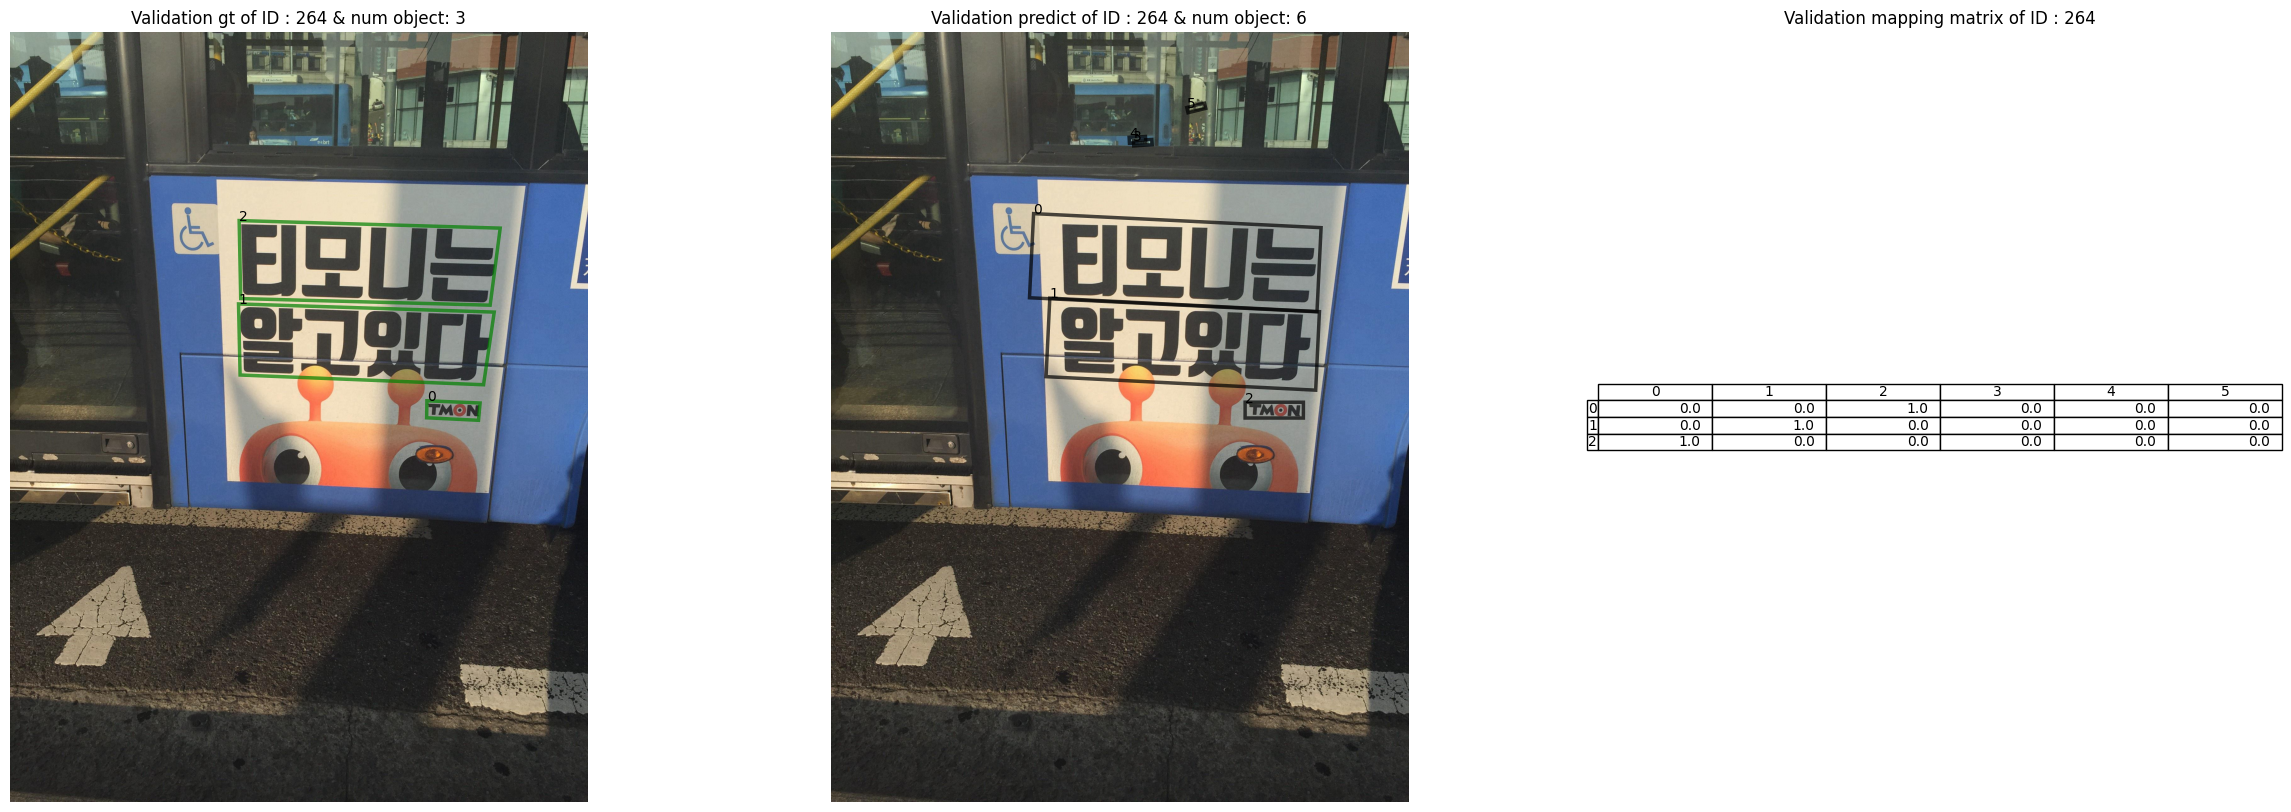

In [20]:
def get_comparison(idx):
    fname= image_fnames[idx]
    image = cv2.imread(osp.join(data_dir,"images",fname))[:, :, ::-1]
    
    #fig,(ax1,ax2)=plt.subplots(1, 2,figsize=(20,40))
    fig,(ax1,ax2,ax3)=plt.subplots(1, 3,figsize=(30,10))
    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')

    ax1.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    ax2.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    ax3.tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)

    ax1.set_title(f'Validation gt of ID : {idx} & num object: {len(gt_dict[fname])}')
    

    for k, gt_bbox in enumerate(gt_dict[fname]):
        ax1.text(
            x = gt_bbox[0][0],
            y = gt_bbox[0][1],
            s = str(k)
        )
        ax1.add_patch(
            patches.Polygon(
            (gt_bbox), #(x1,y1),(x2,y2),(x3,y3),(x4,y4)
            closed=True,
            edgecolor = 'green',
            facecolor = None,
            fill=None,
            alpha=0.7,
            lw=2.5
            )
        )
        
    ax2.set_title(f'Validation predict of ID : {idx} & num object: {len(pred_dict[fname])}')

    for k, predict_bbox in enumerate(pred_dict[fname]):
        ax2.text(
            x = predict_bbox[0][0],
            y = predict_bbox[0][1],
            s = str(k)
        )
        ax2.add_patch(
            patches.Polygon(
            (predict_bbox),
            closed=True,
            edgecolor = 'black',
            facecolor = None,
            fill=None,
            alpha=0.7,
            lw=2.5
     ))    
    ax1.imshow(image)
    ax2.imshow(image)

    ax3.set_title(f'Validation mapping matrix of ID : {idx}')
    the_table = ax3.table(cellText=score[fname][0],
                      colLabels=list(range(len(pred_dict[fname]))),
                      rowLabels=list(range(len(gt_dict[fname]))),
                      fontsize = 40,
                      loc='center')
    
    
    plt.show()

num_idx = random.randint(0,535)
# num_idx = 307
get_comparison(num_idx)
# 19, 121, 188, 100

In [12]:
score[image_fnames[307]]

[array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 0.]]),
 array([[0.        , 0.54015485, 0.        , 0.        ],
        [0.77680685, 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.28580987],
        [0.        , 0.        , 0.        , 0.23636609],
        [0.        , 0.        , 1.        , 0.        ]]),
 array([[0.        , 1.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.82369735],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.43581068, 0.        ]]),
 0.75,
 0.8]